Here we investigate the masses for the three planet hosts:

  - HD33142
  - HD76700
  - HD205739
  
We use the data from GDR2 and directly linked in Simbad.

We will use 3d extinction maps and GDR2mock as prior.

We will use brutus and isochrones packages with different stellar evolutionary tracks to determine the masses.

In [1]:
%pylab inline
import mwdust
from astropy.io import fits
from isochrones.dartmouth import Dartmouth_Isochrone
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel

Populating the interactive namespace from numpy and matplotlib
/home/rybizki/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)

/home/rybizki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

/home/rybizki/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)



In [2]:
# Check the extinction for those stars
# The stilism map (https://stilism.obspm.fr/) yields similar results, i.e. negligible extinction for all targets
dust = mwdust.Combined15()
for item in ["HD33142","HD76700","HD205739"]:
    x = fits.getdata(item + ".fits")
    print(item, "l: ",x.l[0], "b: ",x.b[0], "dist in pc: ",1000/x.parallax[0], "a0: ",dust(x.l[0],x.b[0],1/x.parallax[0])[0])

HD33142 l:  214.33740575205493 b:  -29.226470027615754 dist in pc:  121.79892776659938 a0:  0.011518314377290347
HD76700 l:  282.4895335688957 b:  -13.918724617879588 dist in pc:  60.99031551994843 a0:  0.008497278068466728
HD205739 l:  14.613243663572495 b:  -47.99934132824423 dist in pc:  92.74166705295947 a0:  0.014436753747015758


In [3]:
# Check other parameters of the stars
for item in ["HD33142","HD76700","HD205739"]:
    x = fits.getdata(item + ".fits")
    print(item, "-----------------------------")
    for jtem in ['phot_g_mean_mag',"phot_bp_mean_mag","phot_rp_mean_mag","teff_val"]:
        print(jtem, x[jtem][0])
    print("BP-RP = ",(x.phot_bp_mean_mag - x.phot_rp_mean_mag)[0])

HD33142 -----------------------------
phot_g_mean_mag 7.7127433
phot_bp_mean_mag 8.2059965
phot_rp_mean_mag 7.110064
teff_val 5039.3433
BP-RP =  1.0959325
HD76700 -----------------------------
phot_g_mean_mag 7.9734774
phot_bp_mean_mag 8.359728
phot_rp_mean_mag 7.474292
teff_val 5639.5
BP-RP =  0.88543606
HD205739 -----------------------------
phot_g_mean_mag 8.419914
phot_bp_mean_mag 8.705873
phot_rp_mean_mag 8.01517
teff_val 6157.4
BP-RP =  0.69070244


In [4]:
# Showing the available bands
dar = Dartmouth_Isochrone()
print(dar.bands)
mist = MIST_Isochrone()
print(mist.bands)

/home/rybizki/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)

['B', 'V', 'g', 'r', 'i', 'z', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'Kepler']
['B', 'BP', 'G', 'H', 'J', 'K', 'Kepler', 'RP', 'TESS', 'V', 'W1', 'W2', 'W3', 'g', 'i', 'r', 'z']


In [5]:
# We will simply increase the internal/reported error according to the values 
# for bright stars mentioned in the presentation slide 17 (https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf/1ebddb25-f010-6437-cb14-0e360e2d9f09)
def external_uncertainty(internal_uncertainty):
    k = 1.08
    sigma_s = 0.021# for stars G>13: 0.043
    return(np.sqrt( k**2 * internal_uncertainty**2 + sigma_s**2))

def add_parallax_zero_point(parallax):
    #we take the zero point for brighter sources, not for the quasar sample
    return(parallax+0.050)

def isochrones_wrapper(parallax,mags,model = "mist", verbose = True, zero_ext = True):
    """
    this wrapper runs the isochrones inference and reports the quantiles and corner plots
    
    INPUT:
       parallax: a list or array with parallax[0] = parallax in mas and parallax[1] = uncertainty in mas
       mags: a dictionary with available bands and their uncertainty, e.g. {'B':( 8.905,0.018),'V':(7.96,0.01)}
       model: either "mist" or "dar" to query MIST or Dartmouth isochrones
       verbose: bool, reports percentiles and the corner plots of the important parameters
    OUTPUT:
       sm: the Starmodel object with the resulting samples
    """
    if model == "dar":
        from isochrones.dartmouth import Dartmouth_Isochrone
        sel = Dartmouth_Isochrone()
    elif model == 'mist':
        from isochrones.mist import MIST_Isochrone
        sel = MIST_Isochrone()
    from isochrones import StarModel
    sm = StarModel(sel, parallax=(parallax[0], parallax[1]), **mags)
    if zero_ext:
        from isochrones.priors import FlatPrior
        av_prior = FlatPrior((0,0.05))
        sm._priors['AV'] = av_prior
    sm.fit(refit=True, verbose = True)
    if verbose:
        print("###################################")
        print("using %s isochrone sets" %(model))
        print("using the following photometric data: ", mags)
        print("using the following parallax data: ", parallax)
        print(sm.samples.mass_0_0.quantile([0.16,0.50, 0.86]))
        print(sm.samples.AV_0.quantile([0.16,0.50, 0.86]))
        print(sm.samples.feh_0.quantile([0.16,0.50, 0.86]))
        print(sm.samples.age_0.quantile([0.16,0.50, 0.86]))
        print(sm.samples.distance_0.quantile([0.16,0.50, 0.86]))
        print(sm.samples.radius_0_0.quantile([0.16,0.50, 0.86]))
        print(sm.samples.logL_0_0.quantile([0.16,0.50, 0.86]))
        print(sm.samples.Teff_0_0.quantile([0.16,0.50, 0.86]))
        sm.corner_observed();
        sm.corner_physical();
    return(sm)

/home/rybizki/anaconda3/lib/python3.6/site-packages/isochrones/starmodel.py:487: RuntimeWarning: divide by zero encountered in log
  lnp += np.log(self.prior(prop, val))

/home/rybizki/anaconda3/lib/python3.6/site-packages/isochrones/starmodel.py:487: RuntimeWarning: divide by zero encountered in log
  lnp += np.log(self.prior(prop, val))

###################################
using mist isochrone sets
using the following photometric data:  {'B': (8.905, 0.018), 'V': (7.96, 0.01), 'J': (6.345, 0.018), 'H': (5.903, 0.034), 'K': (5.792, 0.018)}
using the following parallax data:  [[8.2602529 ]
 [0.04742055]]
0.16    1.789699
0.50    1.995946
0.86    2.234743
Name: mass_0_0, dtype: float64
0.16    0.011919
0.50    0.030305
0.86    0.044947
Name: AV_0, dtype: float64
0.16   -0.077683
0.50    0.020245
0.86    0.169386
Name: feh_0, dtype: float64
0.16    5.621513
0.50    5.719597
0.86    5.828399
Name: age_0, dtype: float64
0.16    120.447479
0.50    121.158248
0.86    121.869393
Name: distanc

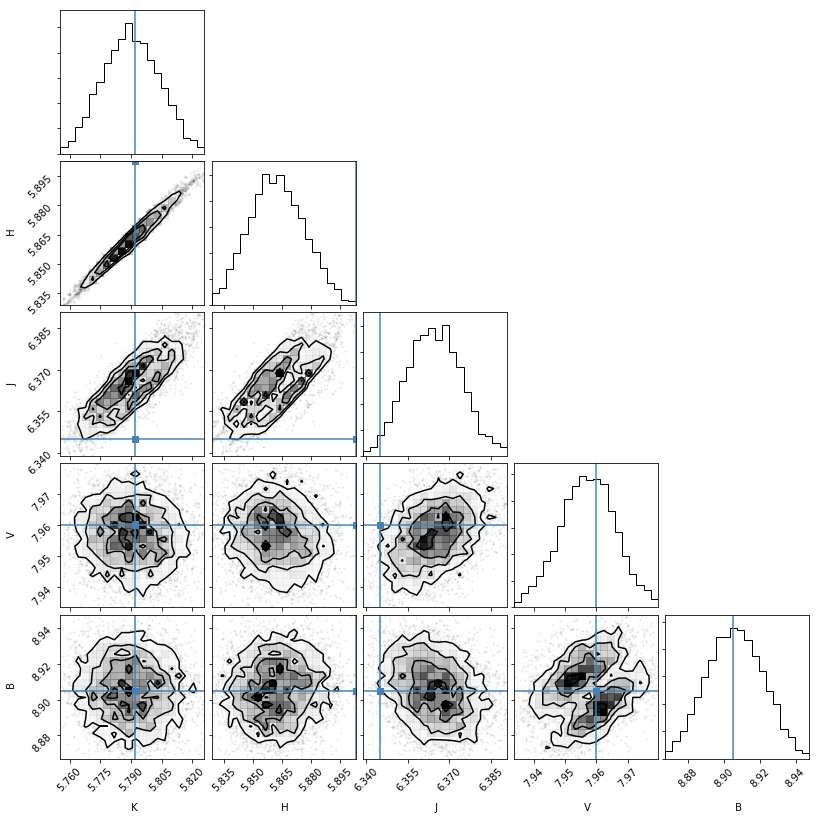

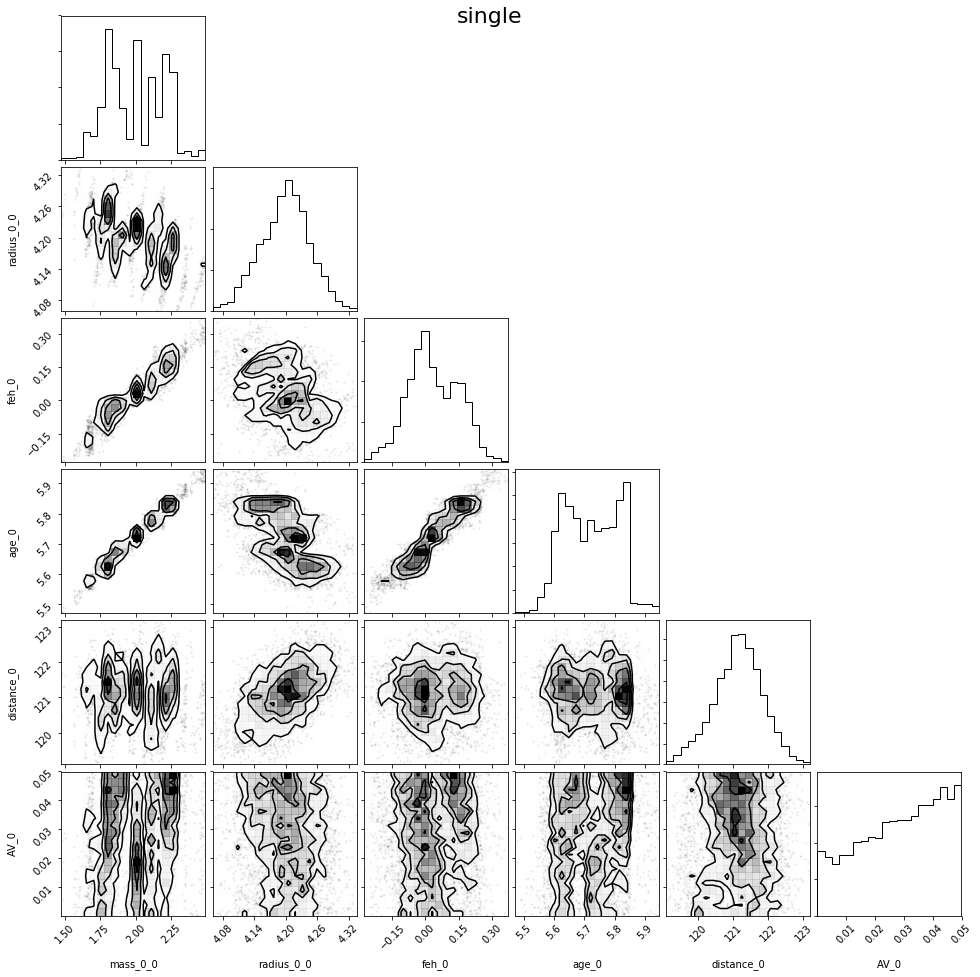

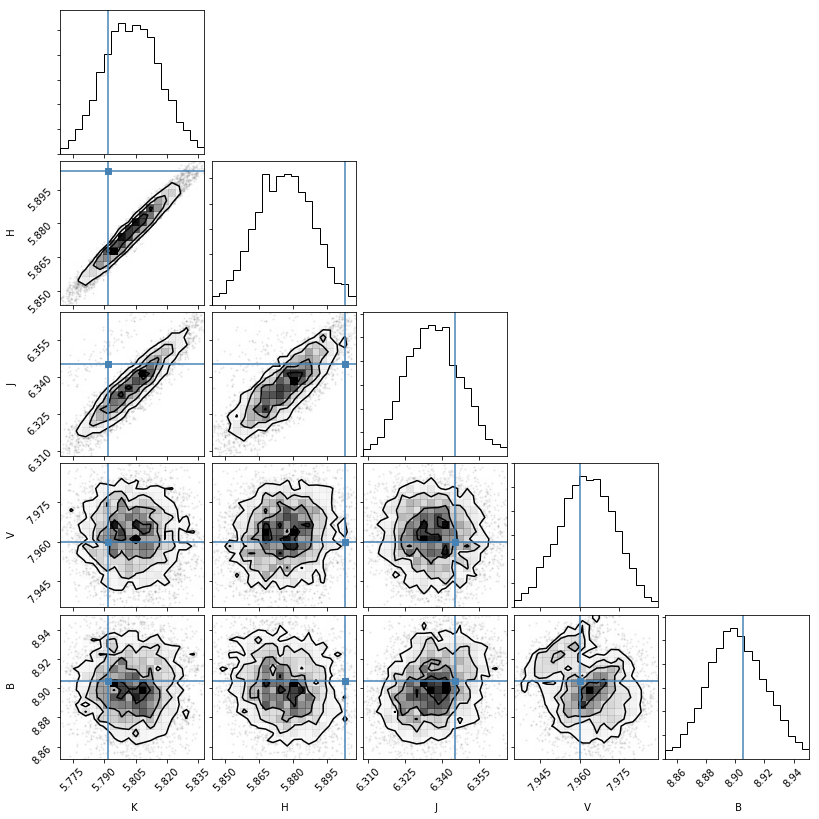

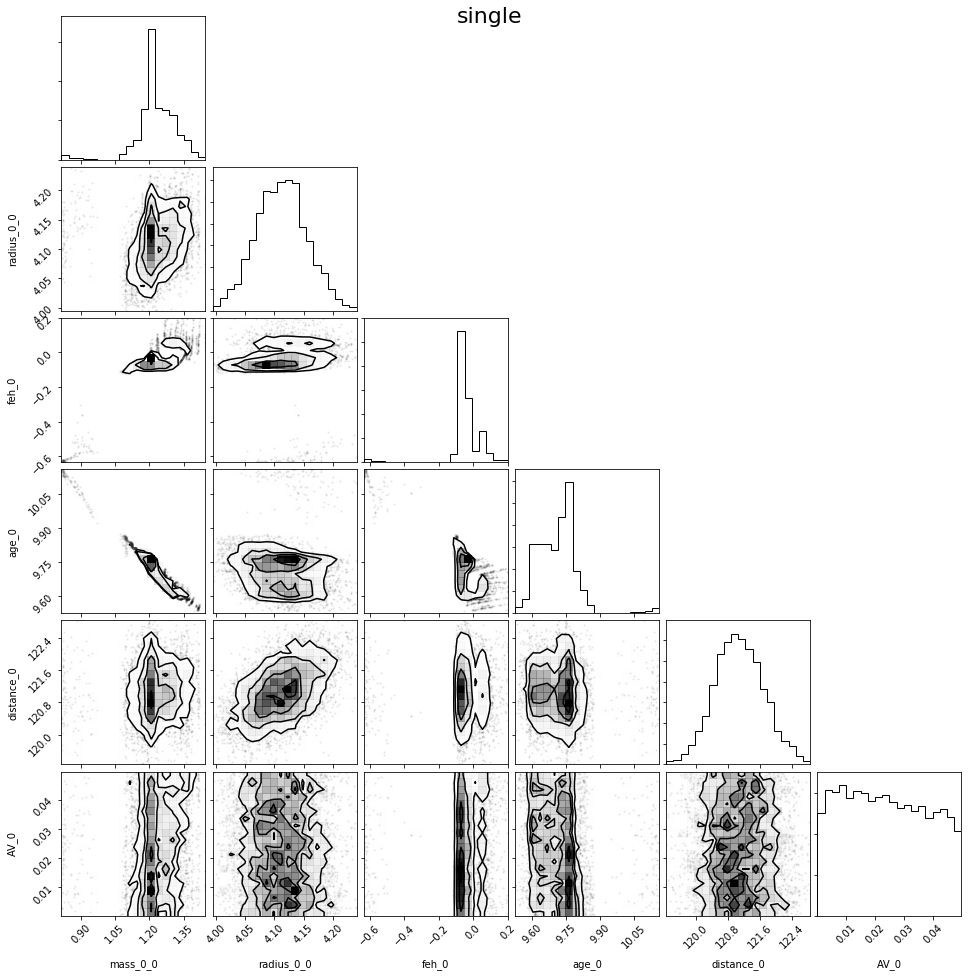

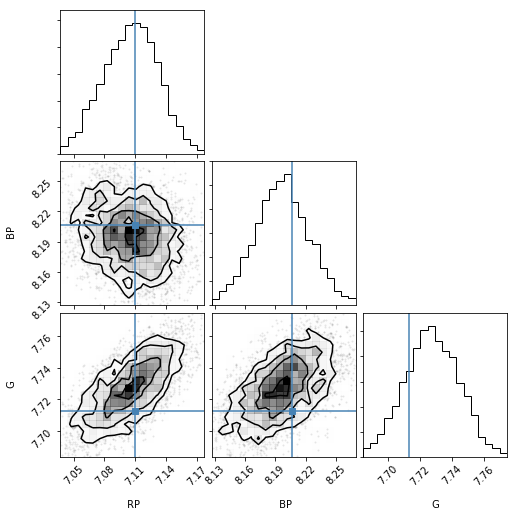

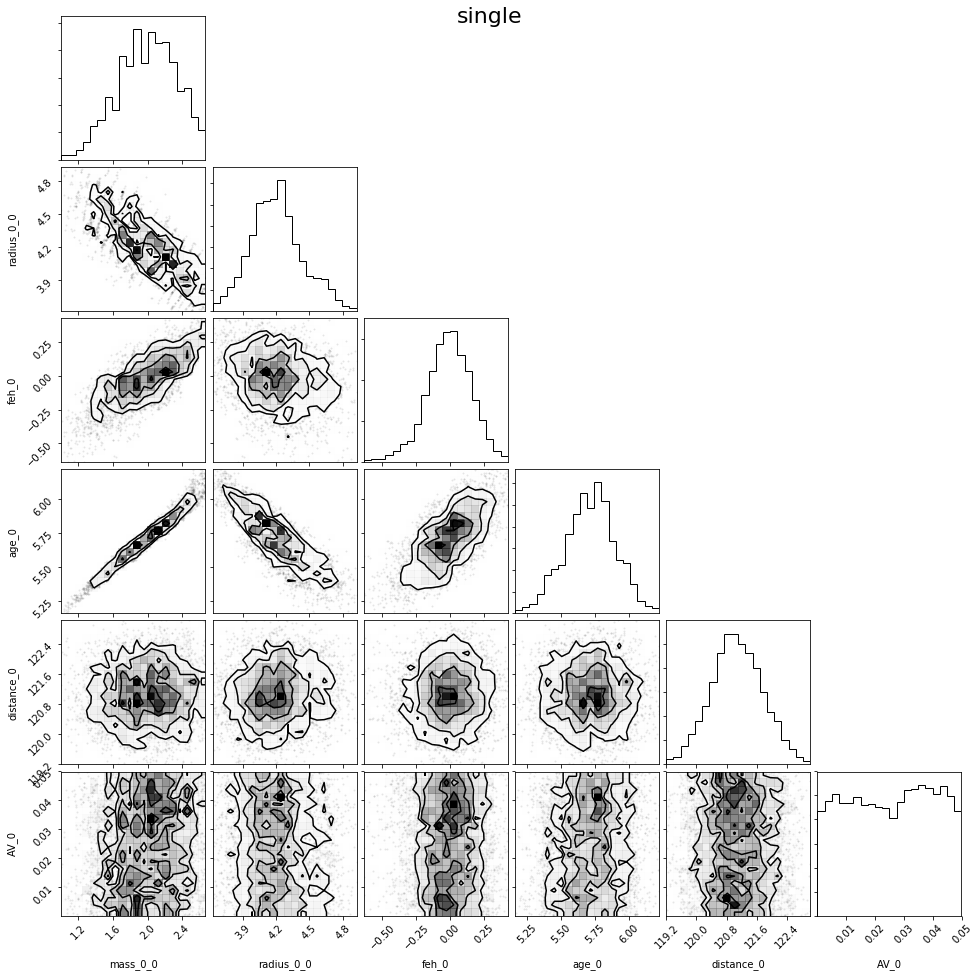

In [6]:
# Data from GDR2
star = "HD33142"
data = fits.getdata(star+".fits")
# Mags taken from SIMBAD
mags = {'B':( 8.905,0.018),'V':(7.96,0.01) ,'J':( 6.345,0.018),'H':(5.903,0.034),'K':( 5.792,0.018)}
parallax = np.array([add_parallax_zero_point(data.parallax),external_uncertainty(data.parallax_error)])

# Initializing the model with the parallax and parallax error information and the observed magnitude data
# Fitting the first model (takes on the order of minutes) and printing the output
_ = isochrones_wrapper(parallax,mags,model = "mist", verbose = True, zero_ext = True)
_ = isochrones_wrapper(parallax,mags,model = "dar", verbose = True, zero_ext = True)

# We inflate the Gaia photometric errors a bit in order to not be too strongly affected by passband biases 
mags = {'G':(data.phot_g_mean_mag,0.03) ,'BP':( data.phot_bp_mean_mag, 0.03),'RP':(data.phot_rp_mean_mag,0.03)}
_ = isochrones_wrapper(parallax,mags,model = "mist", verbose = True, zero_ext = True)

/home/rybizki/anaconda3/lib/python3.6/site-packages/isochrones/starmodel.py:487: RuntimeWarning: divide by zero encountered in log
  lnp += np.log(self.prior(prop, val))

###################################
using mist isochrone sets
using the following photometric data:  {'B': (8.88, 0.02), 'V': (8.13, 0.01), 'J': (6.911, 0.023), 'H': (6.613, 0.036), 'K': (6.5, 0.024)}
using the following parallax data:  [[16.44604569]
 [ 0.03989421]]
0.16    1.121140
0.50    1.129147
0.86    1.168531
Name: mass_0_0, dtype: float64
0.16    0.019064
0.50    0.036342
0.86    0.046951
Name: AV_0, dtype: float64
0.16    0.385504
0.50    0.406130
0.86    0.466613
Name: feh_0, dtype: float64
0.16    9.771563
0.50    9.817068
0.86    9.841809
Name: age_0, dtype: float64
0.16    60.641743
0.50    60.788580
0.86    60.950903
Name: distance_0, dtype: float64
0.16    1.362765
0.50    1.372586
0.86    1.385158
Name: radius_0_0, dtype: float64
0.16    0.231234
0.50    0.237185
0.86    0.242796
Name: logL_0_0, dtype

###################################
using dar isochrone sets
using the following photometric data:  {'B': (8.88, 0.02), 'V': (8.13, 0.01), 'J': (6.911, 0.023), 'H': (6.613, 0.036), 'K': (6.5, 0.024)}
using the following parallax data:  [[16.44604569]
 [ 0.03989421]]
0.16    0.986501
0.50    1.006003
0.86    1.034296
Name: mass_0_0, dtype: float64
0.16    0.008691
0.50    0.026054
0.86    0.042985
Name: AV_0, dtype: float64
0.16    0.019168
0.50    0.103086
0.86    0.212478
Name: feh_0, dtype: float64
0.16     9.952850
0.50    10.001664
0.86    10.034508
Name: age_0, dtype: float64
0.16    60.663825
0.50    60.802190
0.86    60.956738
Name: distance_0, dtype: float64
0.16    1.372939
0.50    1.386299
0.86    1.401825
Name: radius_0_0, dtype: float64
0.16    0.245197
0.50    0.251178
0.86    0.257461
Name: logL_0_0, dtype: float64
0.16    5637.618731
0.50    5669.196667
0.86    5701.289421
Name: Teff_0_0, dtype: float64
###################################
using mist isochrone sets
using 

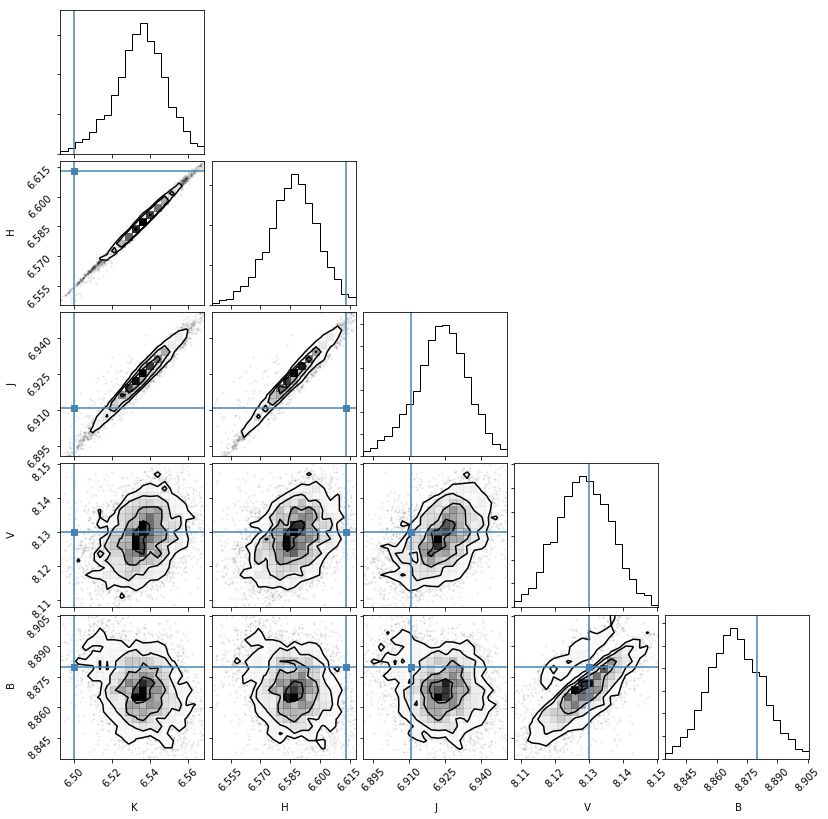

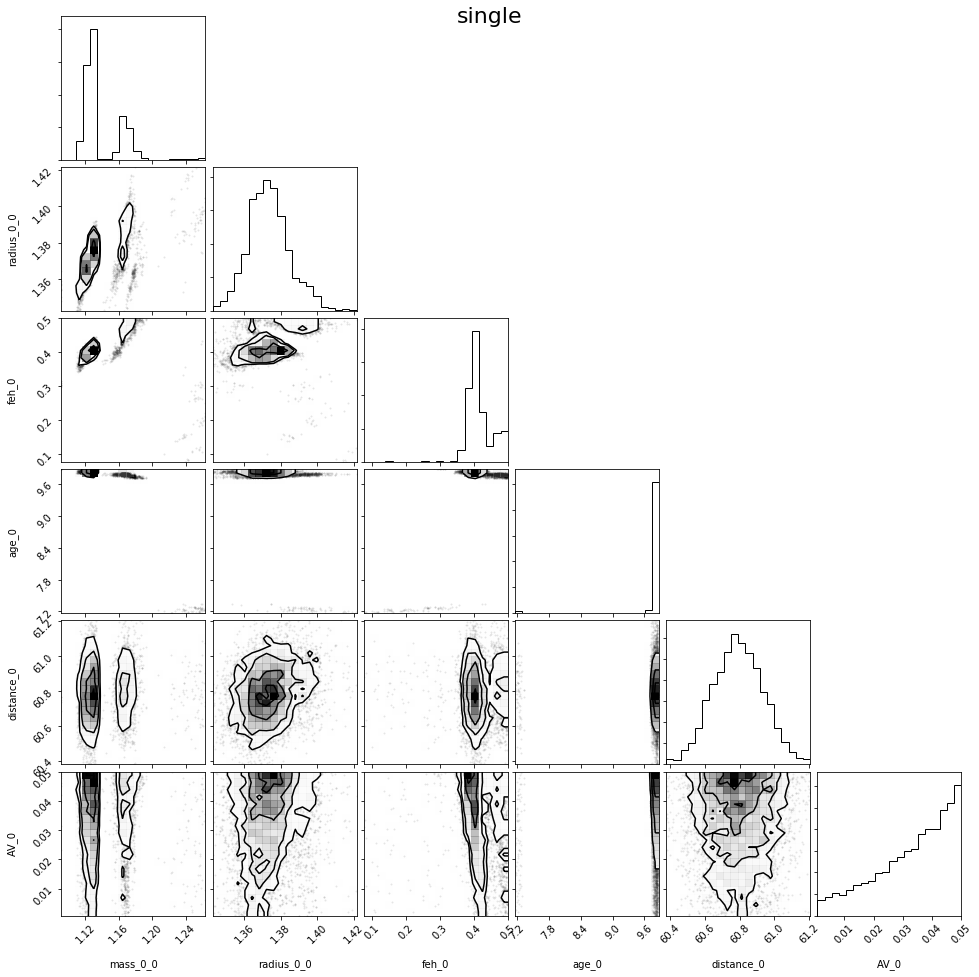

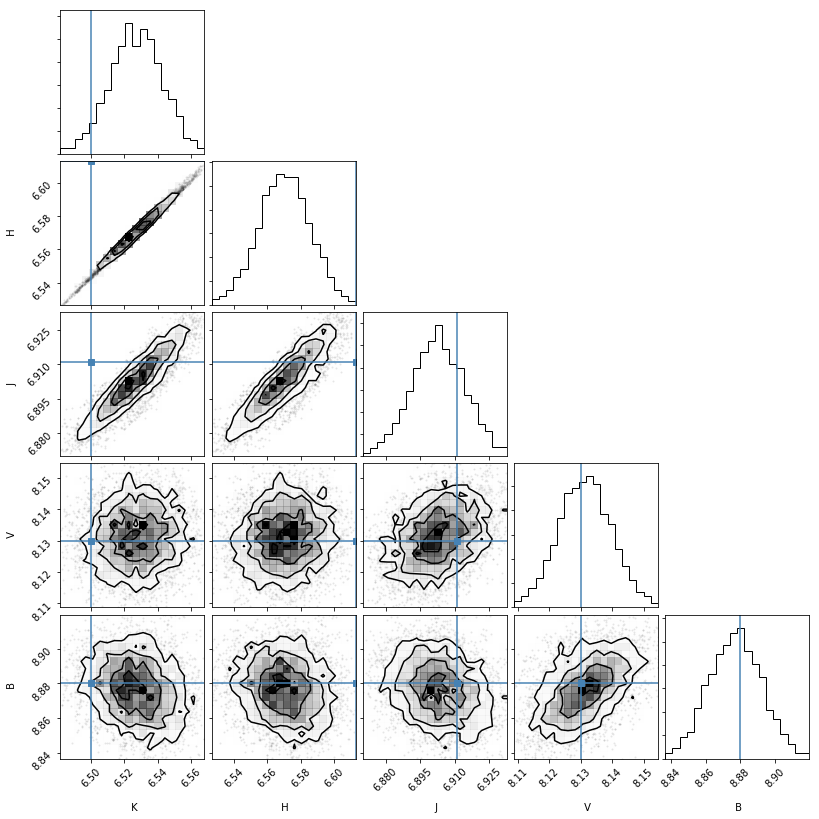

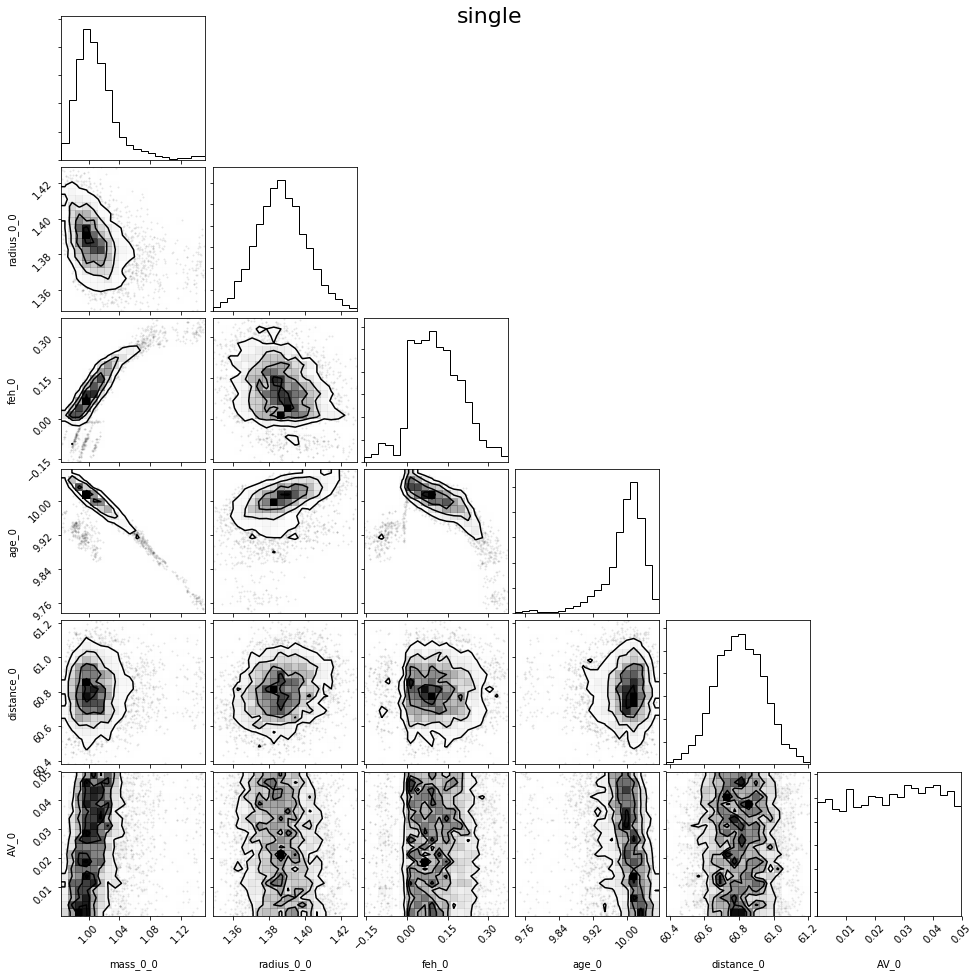

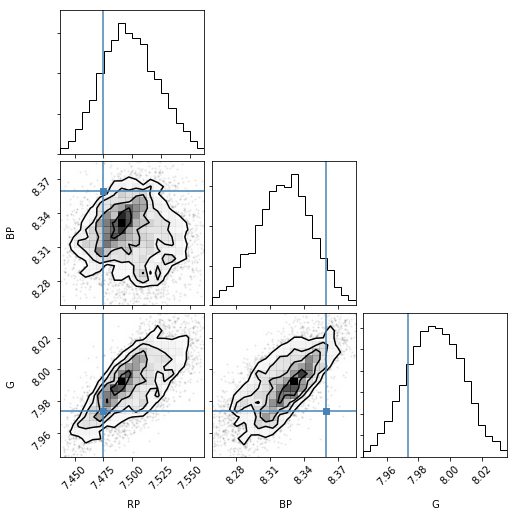

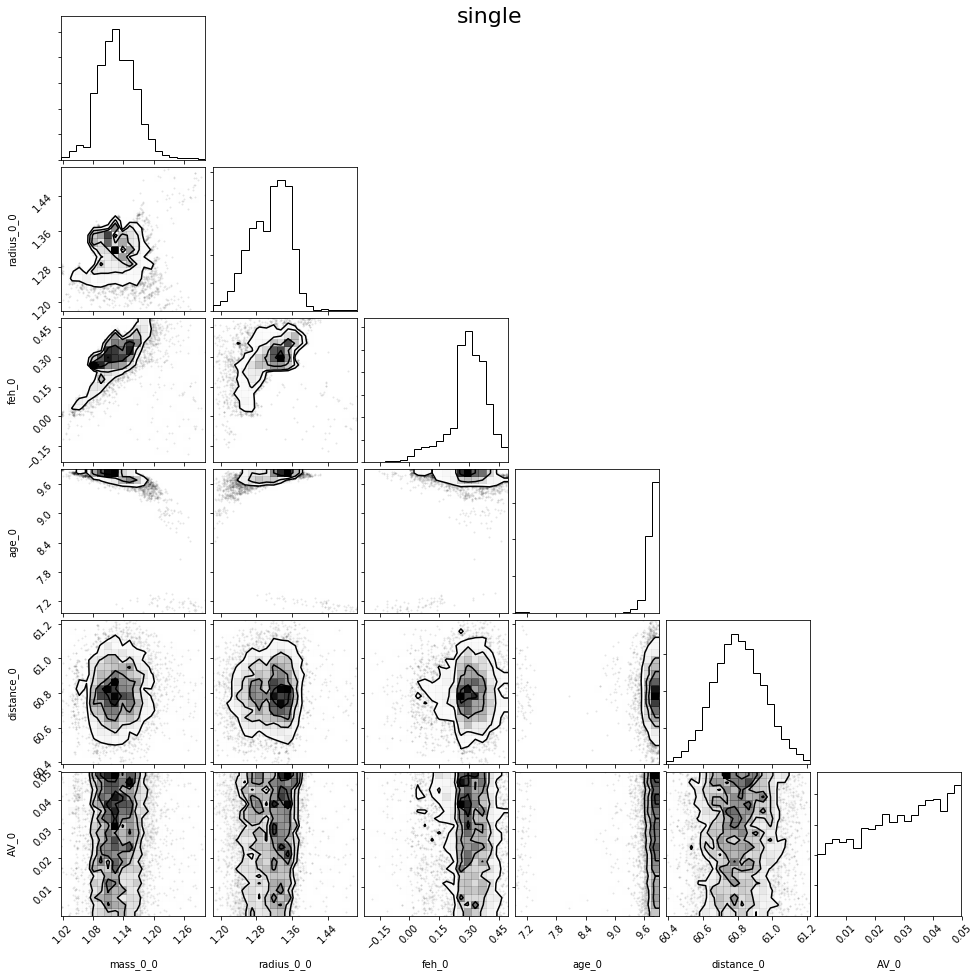

In [7]:
# Data from GDR2
star = "HD76700"
data = fits.getdata(star+".fits")
# Mags taken from SIMBAD
mags = {'B':( 8.88,0.02),'V':(8.13,0.01) ,'J':( 6.911,0.023),'H':(6.613,0.036),'K':( 6.5,0.024)}
parallax = np.array([add_parallax_zero_point(data.parallax),external_uncertainty(data.parallax_error)])

# Initializing the model with the parallax and parallax error information and the observed magnitude data
# Fitting the first model (takes on the order of minutes) and printing the output
_ = isochrones_wrapper(parallax,mags,model = "mist", verbose = True, zero_ext = True)
_ = isochrones_wrapper(parallax,mags,model = "dar", verbose = True, zero_ext = True)

# We inflate the Gaia photometric errors a bit in order to not be too strongly affected by passband biases 
mags = {'G':(data.phot_g_mean_mag,0.03) ,'BP':( data.phot_bp_mean_mag, 0.03),'RP':(data.phot_rp_mean_mag,0.03)}
_ = isochrones_wrapper(parallax,mags,model = "mist", verbose = True, zero_ext = True)

/home/rybizki/anaconda3/lib/python3.6/site-packages/isochrones/starmodel.py:487: RuntimeWarning: divide by zero encountered in log
  lnp += np.log(self.prior(prop, val))

###################################
using mist isochrone sets
using the following photometric data:  {'B': (9.09, 0.02), 'V': (8.54, 0.01), 'J': (7.585, 0.024), 'H': (7.35, 0.038), 'K': (7.299, 0.026)}
using the following parallax data:  [[10.8326399 ]
 [ 0.11306108]]
0.16    1.186059
0.50    1.226267
0.86    1.276317
Name: mass_0_0, dtype: float64
0.16    0.008683
0.50    0.026325
0.86    0.044023
Name: AV_0, dtype: float64
0.16    0.043853
0.50    0.153891
0.86    0.241908
Name: feh_0, dtype: float64
0.16    9.400580
0.50    9.498478
0.86    9.593776
Name: age_0, dtype: float64
0.16    91.354212
0.50    92.258610
0.86    93.309287
Name: distance_0, dtype: float64
0.16    1.381967
0.50    1.402680
0.86    1.423794
Name: radius_0_0, dtype: float64
0.16    0.400758
0.50    0.412370
0.86    0.425186
Name: logL_0_0, dtyp

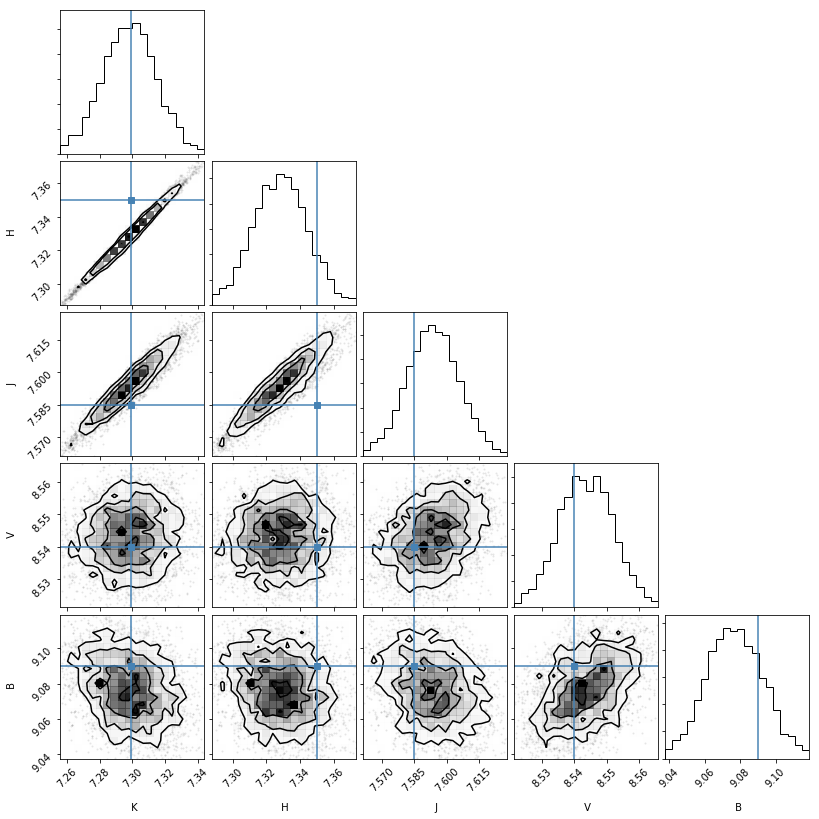

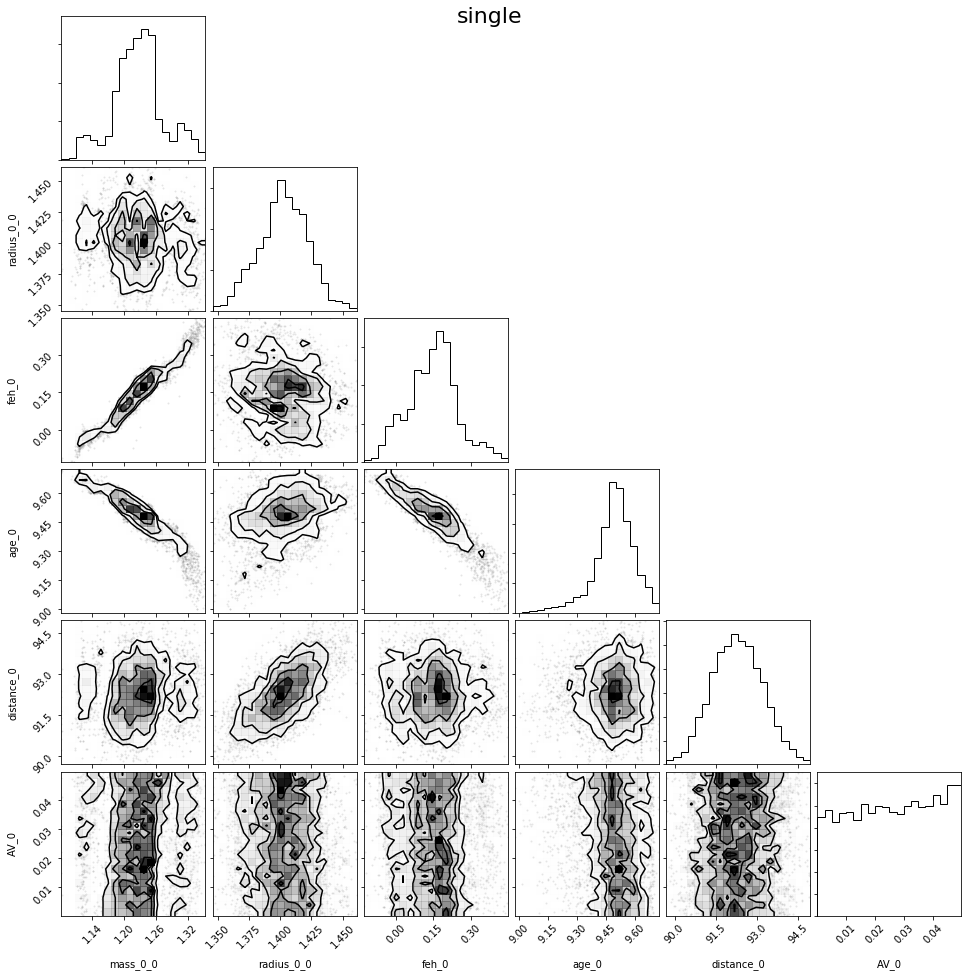

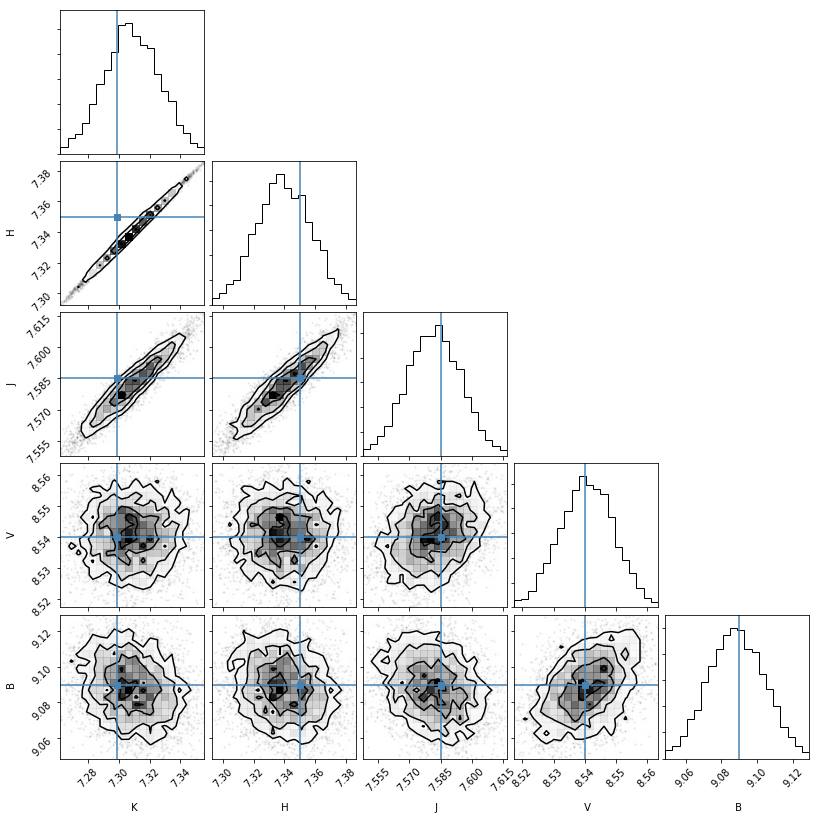

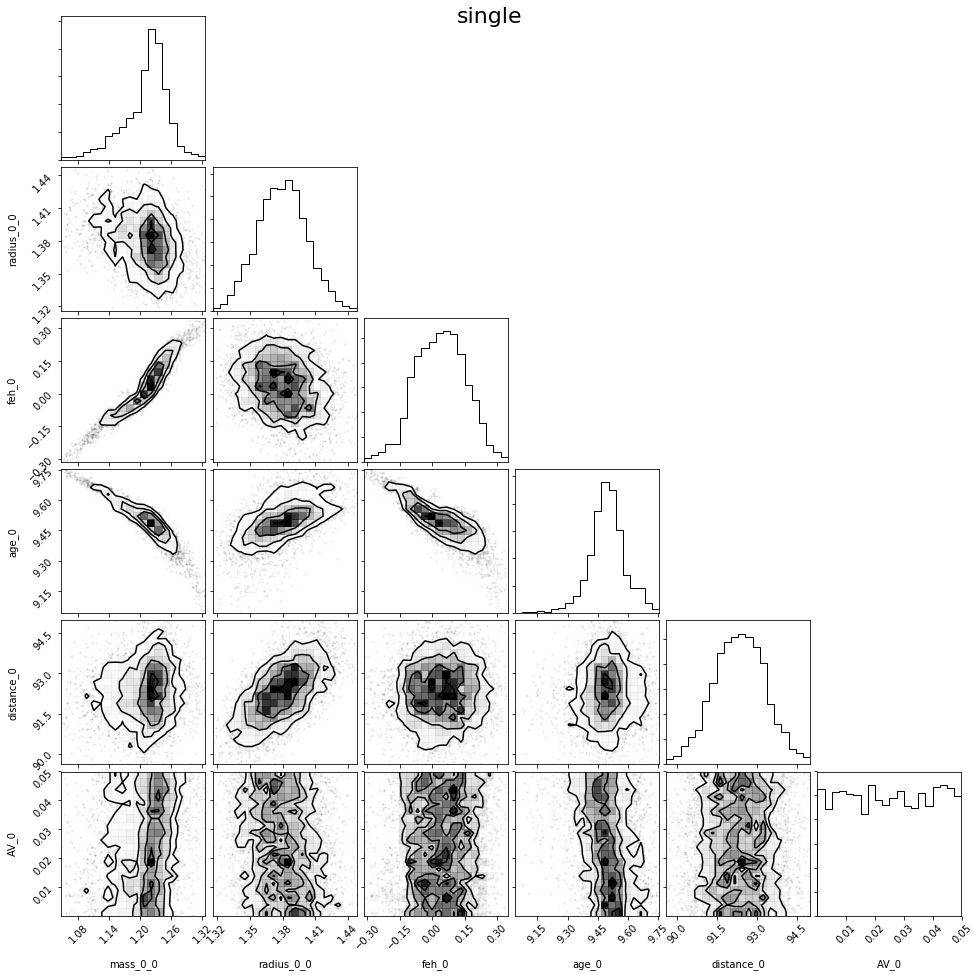

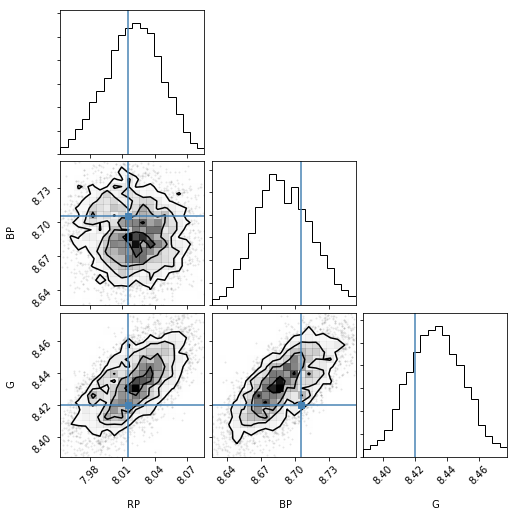

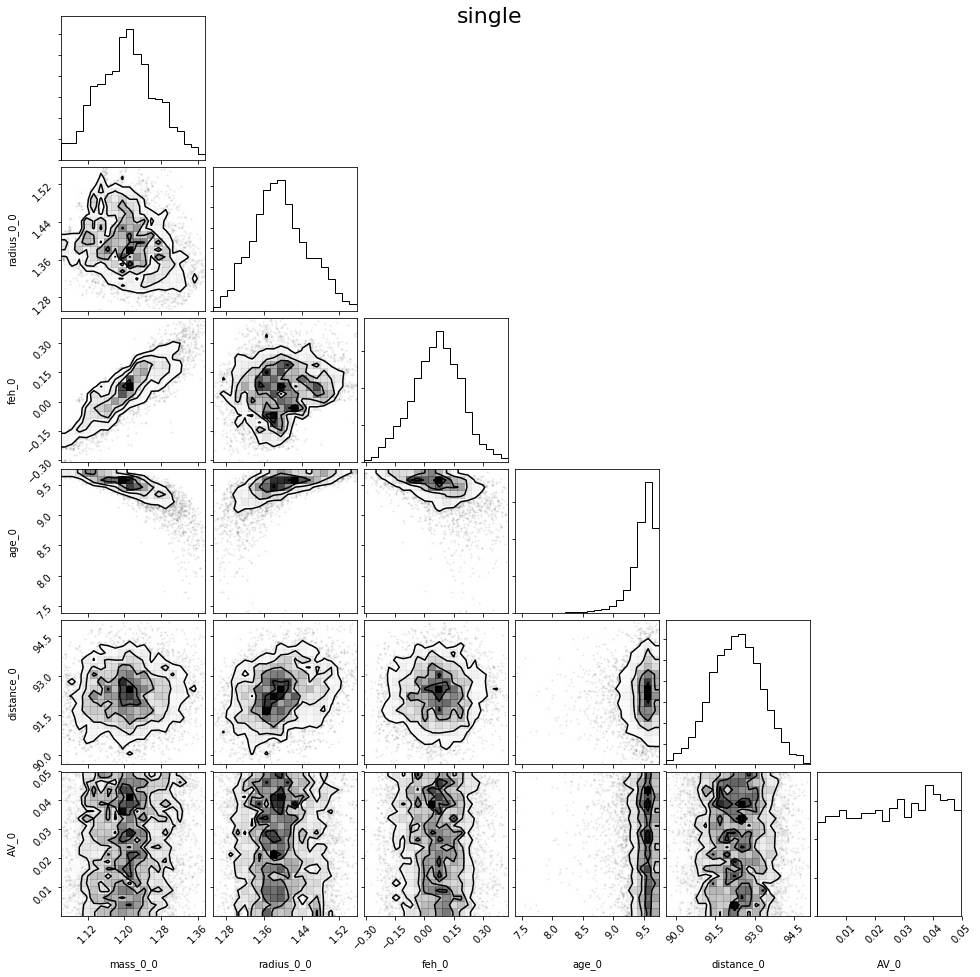

In [8]:
star = "HD205739"
data = fits.getdata(star+".fits")

mags = {'B':( 9.09,0.02),'V':(8.54,0.01) ,'J':( 7.585,0.024),'H':(7.350,0.038),'K':( 7.299,0.026)}
parallax = np.array([add_parallax_zero_point(data.parallax),external_uncertainty(data.parallax_error)])

# Initializing the model with the parallax and parallax error information and the observed magnitude data
# Fitting the first model (takes on the order of minutes) and printing the output
_ = isochrones_wrapper(parallax,mags,model = "mist", verbose = True, zero_ext = True)
_ = isochrones_wrapper(parallax,mags,model = "dar", verbose = True, zero_ext = True)

# We inflate the Gaia photometric errors a bit in order to not be too strongly affected by passband biases 
mags = {'G':(data.phot_g_mean_mag,0.03) ,'BP':( data.phot_bp_mean_mag, 0.03),'RP':(data.phot_rp_mean_mag,0.03)}
_ = isochrones_wrapper(parallax,mags,model = "mist", verbose = True, zero_ext = True)